# LastFM Recommender Genre Topic Modeling
July [X], 2018

In [1]:
import sys
sys.executable

'/Users/brianmcmahon/anaconda3/envs/recommender/bin/python'

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from os import path, getcwd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

from PIL import Image

import gensim
from gensim import matutils, models

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

CWD = '/Volumes/BC_Clutch/Dropbox/recommender_system/'

In [3]:
# sets output to three decimals
pd.set_option('display.float_format',lambda x: '%.3f' %x)

In [4]:
tag_data = pd.read_csv('../data/recsys_tags2.csv')
tag_data = tag_data.set_index(['idx'])
tag_data['tags'] = tag_data['tags'].apply(lambda x: ', '.join(x.split('|')))
tag_data.head()

name                                               tags
idx                                                                       
0          3 Doors Down  00s, 2008, 90s, acoustic, acoustic rock, alter...
1    30 Seconds to Mars  00s, <3, acoustic, addictive, alternative, alt...
2                 3OH!3  00s, 10s, 2007, 2008, 2009, 2010, <3, addictiv...
3               50 Cent  00s, american, awesome, catchy, club, dance, g...
4     A Day to Remember  <3, acoustic, alternative, american, christian...

In [5]:
tag_data.tags[0]

'00s, 2008, 90s, acoustic, acoustic rock, alternative, alternative rock, american, awesome, cute, grunge, guilty pleasure, hard rock, love, male vocalists, melancholic, other great tracks, pop, pop rock, post-grunge, prejebeno, punk, rock, romantic, soft rock, soundtrack'

### Assumptions

In [6]:
data = tag_data.tags
n_topics = 6
seed = 42
ngram_range = (1,3)
ncols = 2

sw = set(STOPWORDS)

adds = ['rock','pop','hardcore']
for word in adds:
    sw.add(word)


### K Means Clustering + tSNE

In [150]:
def generate_wordcloud(text): 
    mask=np.array(Image.open(path.join(CWD,'data/guitar_mask.png')))
#     image_colors=ImageColorGenerator(mask)
    
    wc = WordCloud(background_color='white',
#                           color_func=image_colors,
                          max_words=2000,
                          mask=mask,
#                           max_font_size=90,
                          random_state=seed,
                          colormap='magma',
                          stopwords=sw)
    wc.generate(text)
    
#     wc.to_file(path.join(CWD,"alice.png"))
    
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
#     plt.figure(figsize=[10,10])
#     plt.figure()
#     plt.imshow(mask,cmap=plt.cm.gray, interpolation="bilinear")
#     plt.axis("off")
#     plt.show()
#     plt.imshow(wc.recolor(color_func=image_colors),interpolation="bilinear")
#     plt.axis("off")
#     _=plt.show()

#     plt.imshow(wc, 
#                interpolation="bilinear") 
#     plt.axis("off")
    title = "Topic {}".format(i)
    plt.title(title,fontweight='bold',fontsize=16)   


In [77]:
tfidf = TfidfVectorizer(max_df=0.6)
X = tfidf.fit_transform(data)
nmf = NMF(n_components=n_topics, random_state=seed, alpha=.1, l1_ratio=.5, init='nndsvd')
X_reduced = nmf.fit_transform(X)

KMC saved at ../charts/kmc.png
Inertia score: 3.2557713013456424
Silhouette score: 0.4640277002561153
Cluster 0 has 137 comments.
Cluster 1 has 60 comments.
Cluster 2 has 60 comments.
Cluster 3 has 38 comments.
Cluster 4 has 131 comments.
Cluster 5 has 79 comments.


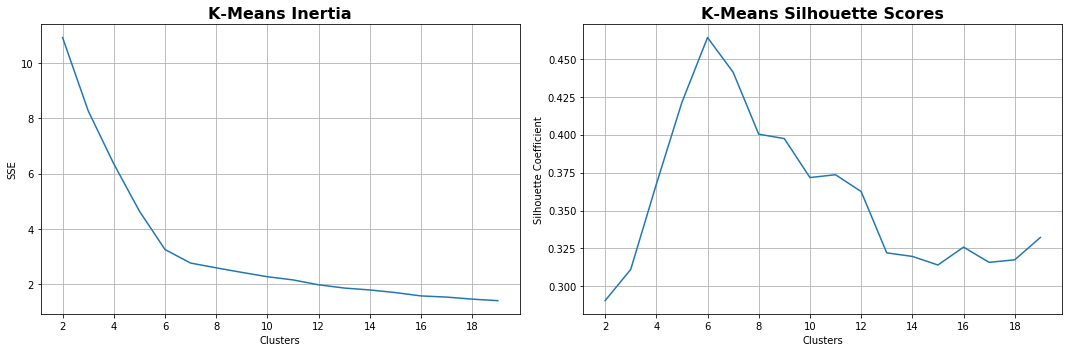

In [80]:
# plot K Means Clusters Silhouette and Clusters Analysis
ns = np.arange(2, 20, 1)
inertias = []
silhouettes = []
for n in ns:
    kmeans = KMeans(n_clusters=n, init="k-means++", random_state=seed).fit(X_reduced)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    ss = silhouette_score(X_reduced, labels, metric='euclidean',sample_size=5000, random_state=seed)
    silhouettes.append(ss)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
# plot the inertia scores and look for the kink in the curve
plt.plot(ns, inertias)
# plt.axis([0, 20, 0, 1])
plt.xticks(np.arange(min(ns), max(ns)+1, 2.0))
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.title('K-Means Inertia', fontweight='bold',fontsize=16)
plt.grid()

ax = fig.add_subplot(1,2,2)
# plot the silhouette scores
plt.plot(ns, silhouettes)
# plt.axis([0, 20, 0, 1])
plt.xticks(np.arange(min(ns), max(ns)+1, 2.0))
plt.xlabel('Clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('K-Means Silhouette Scores', fontweight='bold',fontsize=16)
plt.grid()

plt.tight_layout()
filepath1 = "../charts/kmc.png"
plt.savefig(filepath1)
print("KMC saved at " + filepath1)
# Fit Kmeans with n_clusters
kmeans = KMeans(n_clusters=n_topics, init="k-means++", random_state=seed)
kmf = kmeans.fit(X_reduced)
labels = kmf.labels_
ssc = silhouette_score(X_reduced, labels, metric='euclidean',sample_size=5000, random_state=seed)

print("Inertia score: {}".format(kmf.inertia_))
print("Silhouette score: {}".format(ssc))
for cluster in range(len(set(labels))):
    print("Cluster {} has {} comments.".format(cluster, sum(labels==cluster)))

WordClouds saved at ../charts/wc_kmctsne.png


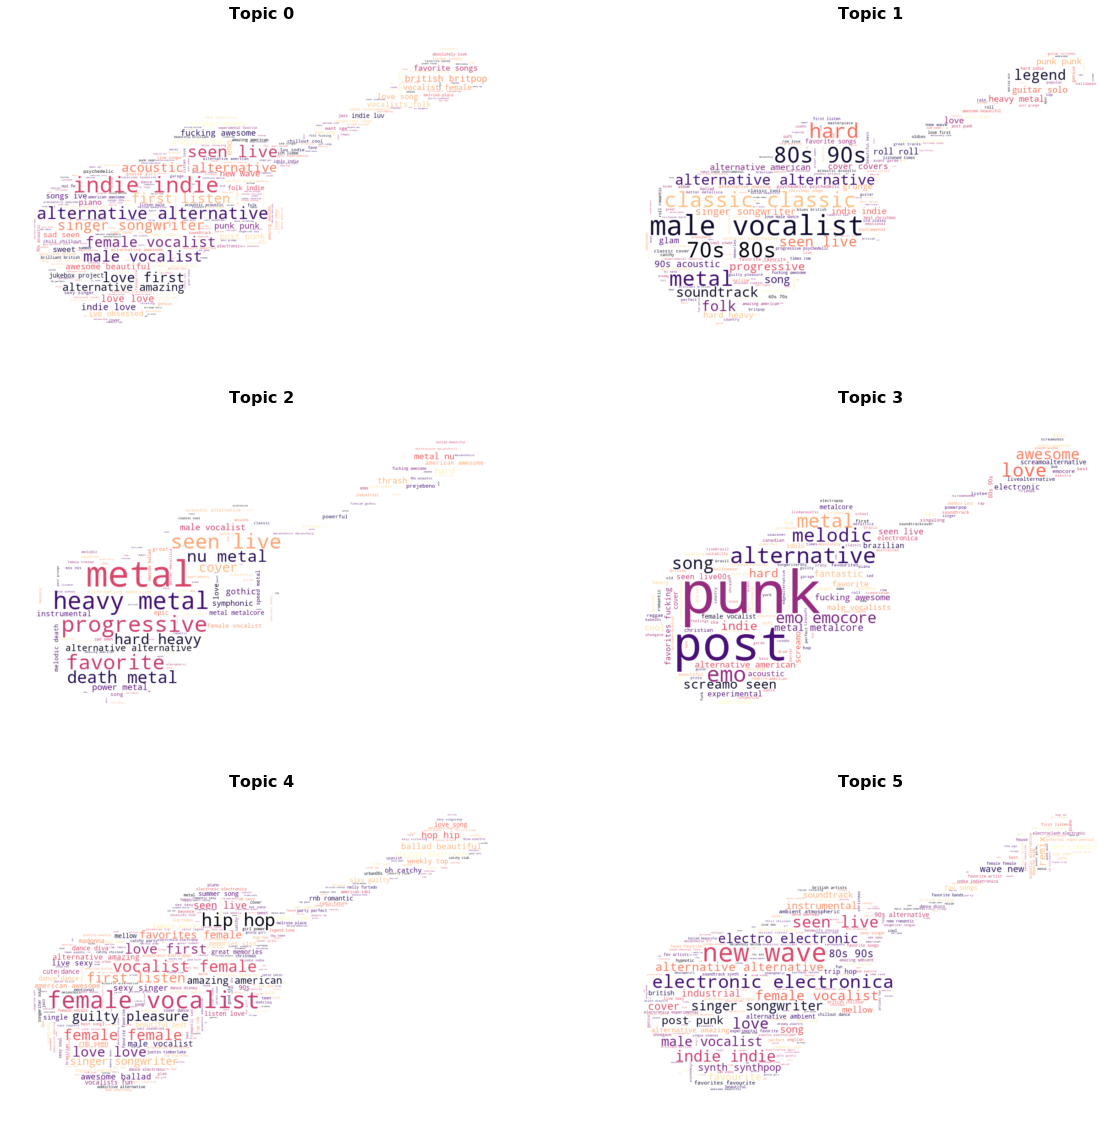

In [154]:
cluster_map = pd.DataFrame(X_reduced)
cluster_map['comments'] = [r for r in data]
cluster_map['cluster'] = labels

fig = plt.figure(figsize=(20,20))
# ncols = 2
nrows = math.ceil(n_topics / ncols)
# plt.tight_layout()

for i in range(n_topics):
    ax = fig.add_subplot(nrows,ncols,i+1)
    text = ''.join(cluster_map[cluster_map.cluster==i].comments)
    
    generate_wordcloud(text)   
    
filepath3 = "../charts/wc_kmctsne.png"
print("WordClouds saved at " + filepath3)
plt.savefig(filepath3)

T-SNE saved at ../charts/tsne.png


<Figure size 4320x4320 with 0 Axes>

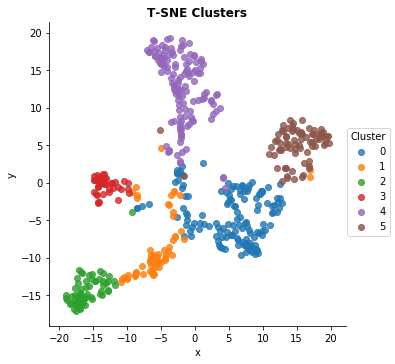

In [18]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=500, random_state=seed)
tsne = tsne.fit_transform(X_reduced)
df_tsne = pd.DataFrame(tsne, columns=["tsne_x", "tsne_y"])
df_tsne["Cluster"] = labels

fig = plt.figure(figsize=(60,60))
tsne = sns.lmplot("tsne_x", "tsne_y", data=df_tsne, fit_reg=False, hue="Cluster")
plt.xlabel("x")
plt.ylabel("y")
plt.title("T-SNE Clusters",fontweight='bold')
filepath2 = "../charts/tsne.png"
plt.savefig(filepath2)
print("T-SNE saved at " + filepath2)

In [19]:
# TODO determine issue with data loading to google embedding projector
# https://projector.tensorflow.org/
vectors = pd.DataFrame(X_reduced)
meta = pd.DataFrame(df_tsne['Cluster'])
print(vectors.shape, meta.shape)
meta.to_csv('../data/recsys_tags_tab_meta.tsv',sep='\t',index=False,header=False)
vectors.to_csv('../data/recsys_tags_tab_vectors.tsv',sep='\t',index=False,header=False)

(505, 6) (505, 1)


In [20]:
vectors.head()

0     1     2     3     4     5
0 0.051 0.003 0.024 0.023 0.115 0.000
1 0.100 0.059 0.046 0.113 0.037 0.020
2 0.029 0.030 0.167 0.000 0.000 0.052
3 0.000 0.000 0.141 0.000 0.000 0.000
4 0.010 0.002 0.000 0.295 0.009 0.000

In [21]:
df_tsne['Cluster'].shape

(505,)

In [22]:
data.head()

idx
0    00s, 2008, 90s, acoustic, acoustic rock, alter...
1    00s, <3, acoustic, addictive, alternative, alt...
2    00s, 10s, 2007, 2008, 2009, 2010, <3, addictiv...
3    00s, american, awesome, catchy, club, dance, g...
4    <3, acoustic, alternative, american, christian...
Name: tags, dtype: object

In [23]:
print(vectors.shape)
meta.shape

(505, 6)


(505, 1)

### LDA

In [24]:
# data = tag_data.tags
# num_topics = 6
# ngram_range = (1,2)
max_words = 10

# seed = 42
# n_clusters = 6

In [25]:
from gensim import corpora

Chart saved at ../charts/5.png


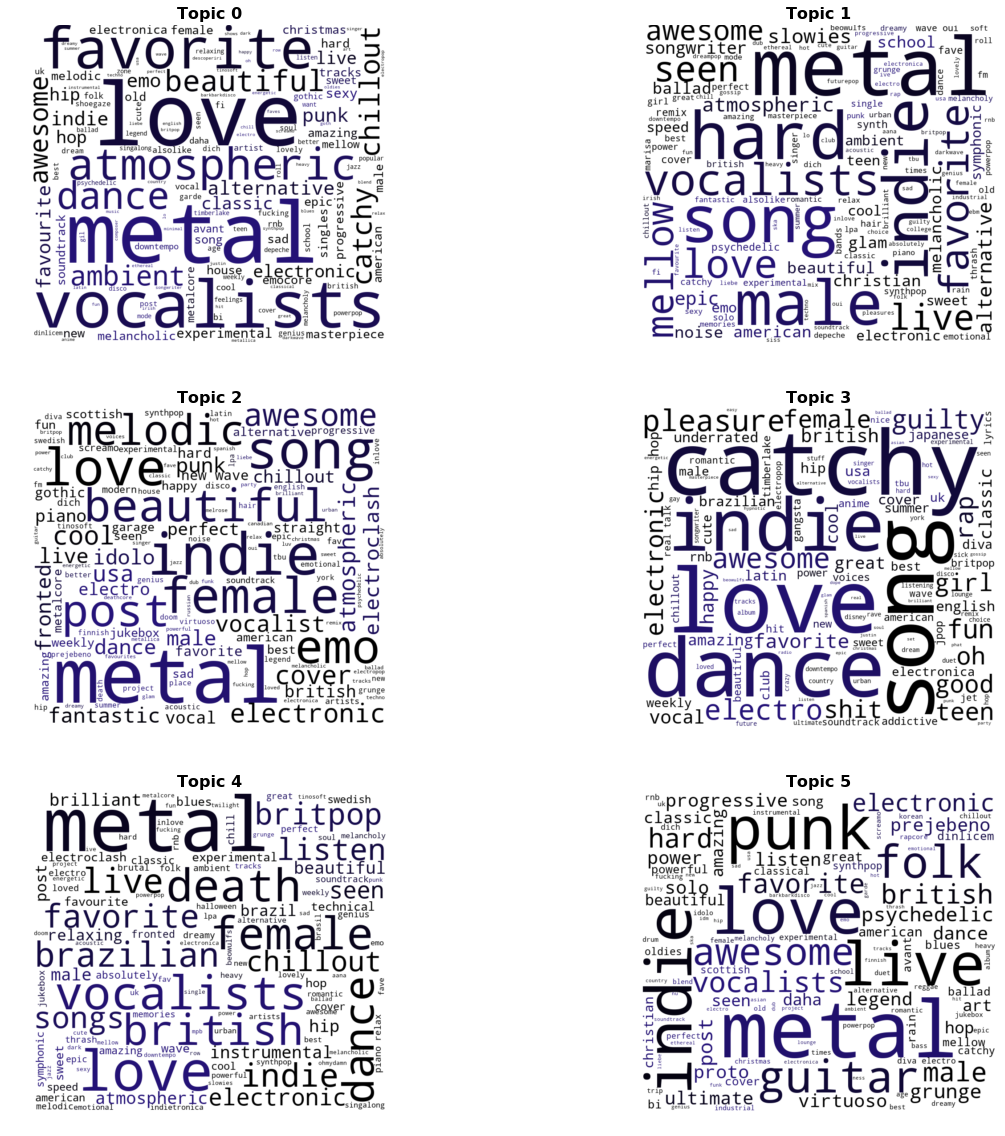

In [26]:
fig = plt.figure(figsize=(20,20))
topics_dict = {}
count_vectorizer = CountVectorizer(ngram_range=ngram_range,  stop_words='english', max_df=0.02, token_pattern="\\b[a-z][a-z]+\\b")
count_vectorizer.fit(data)
counts = count_vectorizer.transform(data).transpose()
corpus = matutils.Sparse2Corpus(counts)
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, num_topics=n_topics, id2word=id2word, passes=10) # minimum_probability=0.03, 
lda_corpus = lda[corpus]
lda_docs = [doc for doc in lda_corpus]
topics = lda.print_topics(num_words=200)
i = 0
for topic in topics:
#     print(topic)
    topics_dict[topic[0]] = lda_docs # , lda.log_perplexity
    nrows = math.ceil(n_topics / ncols)
    ax = fig.add_subplot(nrows,ncols,i+1)
    topics_dict[topic[0]] = topic
    title = " Topic: " + str(topic[0])
    filepath = '../charts/' + str(topic[0]) + '.png'
    
    generate_wordcloud(topic[1])

    i+=1
plt.savefig(filepath)
print("Chart saved at {}".format(filepath))

In [27]:
from nltk import word_tokenize
import re

def clean_text(text):
    tokenized_text = word_tokenize(text.lower())
    cleaned_text = [t for t in tokenized_text if t not in sw and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]
    return cleaned_text

def return_max(tuple_list):
    x_max=0
    y_max=0
    for tup in tuple_list:
        x,y = tup
        if y >y_max:
            y_max=y
            x_max=x
    return x_max, y_max

<input>:6: DeprecationWarning: invalid escape sequence \-
<input>:6: DeprecationWarning: invalid escape sequence \-
<input>:6: DeprecationWarning: invalid escape sequence \-
<ipython-input-27-3e6dc882a89b>:6: DeprecationWarning: invalid escape sequence \-
  cleaned_text = [t for t in tokenized_text if t not in sw and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]


In [28]:
tokenized_data = []
for text in data:
    tokenized_data.append(clean_text(text))

In [29]:
dictionary = corpora.Dictionary(tokenized_data)

In [30]:
corpus = [dictionary.doc2bow(text) for text in tokenized_data]

In [31]:
print(corpus[20])

[(18, 1), (27, 1), (29, 2), (30, 1), (45, 1), (88, 1), (90, 1), (182, 1)]


In [32]:
lda_model = models.LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary)

In [33]:
lsi_model = models.LsiModel(corpus=corpus, num_topics=n_topics, id2word=dictionary)

In [34]:
print("LDA Model:")
 
for idx in range(n_topics):
    # Print the first 4 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 4))
 
print("=" * 20)
 
print("LSI Model:")
 
for idx in range(n_topics):
    # Print the first 4 most representative topics
    print("Topic #%s:" % idx, lsi_model.print_topic(idx, 4))
 
print("=" * 20)

LDA Model:
Topic #0: 0.043*"love" + 0.042*"female" + 0.023*"indie" + 0.018*"vocalists"
Topic #1: 0.049*"indie" + 0.027*"alternative" + 0.023*"favorite" + 0.021*"live"
Topic #2: 0.045*"alternative" + 0.036*"indie" + 0.026*"love" + 0.024*"metal"
Topic #3: 0.102*"metal" + 0.031*"alternative" + 0.022*"indie" + 0.022*"live"
Topic #4: 0.031*"female" + 0.024*"vocalists" + 0.021*"alternative" + 0.020*"live"
Topic #5: 0.043*"alternative" + 0.030*"indie" + 0.029*"love" + 0.029*"female"
LSI Model:
Topic #0: 0.334*"love" + 0.303*"alternative" + 0.302*"indie" + 0.286*"female"
Topic #1: -0.865*"metal" + 0.179*"female" + -0.152*"hard" + 0.134*"love"
Topic #2: -0.553*"female" + 0.416*"indie" + 0.280*"alternative" + -0.216*"metal"
Topic #3: -0.426*"indie" + 0.325*"favorite" + 0.251*"new" + 0.237*"classic"
Topic #4: 0.345*"punk" + -0.292*"female" + -0.288*"indie" + 0.264*"male"
Topic #5: 0.433*"punk" + -0.336*"love" + 0.319*"alternative" + 0.227*"new"


In [35]:
tag_data.head()

name                                               tags
idx                                                                       
0          3 Doors Down  00s, 2008, 90s, acoustic, acoustic rock, alter...
1    30 Seconds to Mars  00s, <3, acoustic, addictive, alternative, alt...
2                 3OH!3  00s, 10s, 2007, 2008, 2009, 2010, <3, addictiv...
3               50 Cent  00s, american, awesome, catchy, club, dance, g...
4     A Day to Remember  <3, acoustic, alternative, american, christian...

In [36]:
bs_text = ''.join(tag_data[tag_data['name']=='Britney Spears']['tags'])

In [37]:
bs_text

"00s, 10s, 2007, 2008, 2009, 90's, 90s, <3, acoustic, addictive, alternative, amazing, american, awesome, ballad, beautiful, best, best christmas songs, best song ever, best songs of the 00s, beyonce, britney spears, catchy, christmas, classic, cool, country, cover, covers, cute, dance, dance-pop, disco, disney, diva, dubstep, electro, electro pop, electronic, electronica, electropop, emotional, energetic, english, epic, favorite, favorites, favourites, female, female vocalist, female vocalists, female voices, fun, gay, girl power, glam, gossip girl, great, great memories with my siss, guilty pleasure, guilty pleasures, handclaps, hot, justin timberlake, latin, legend, love, love at first listen, love it, loved, lovely, masterpiece, melodic, nice, oh so catchy, party, perfect, pop, pop covers, pop rock, pop singles, punk rock, remix, rnb, rock, sad, seen live, sensual, sex, sexy, singer-songwriter, soundtrack, summer song, sweet, tbu, teen pop, the best, top 40, underrated, urban, usa,

In [38]:
bow = dictionary.doc2bow(clean_text(text))

In [39]:
def return_topic(text, algorithm):
    bow = dictionary.doc2bow(clean_text(text))
    if algorithm == 'LSI':
        return return_max(lsi_model[bow])
    elif algorithm == 'LDA':
        return return_max(lda_model[bow])
    else:
        return None

In [40]:
print(return_topic(bs_text, 'LSI'))
print(return_topic(bs_text, 'LDA'))

(0, 8.565818613808872)
(0, 0.9925622)


In [41]:
def return_genre(tup):
    genre_list = ['electronic','rock','rock','pop','electronic','urban', # 0 - 5
                  'rock', 'electronic','alternative','electronic','pop'] # 6 - 10
    topic_num = tup[0]
    
#     'pop' = return_topic()
    
    return genre_list[topic_num]

In [42]:
# def return_artist_topic(artist):
#     text = ''.join(tag_data[tag_data['name']==artist]['tags'])
#     bow = dictionary.doc2bow(clean_text(text))
#     return return_max(lda_model[bow])[0]
    

In [43]:
# return_artist_topic('Justin Timberlake')

In [44]:
# return_artist_topic('Frank Sinatra')

In [45]:
# return_artist_topic('Green Day')

In [46]:
# def return_genre(topic_tuple):
#     genre_dict = {}
#     genre_dict['rock'] = return_artist_topic('Foo Fighters')
#     genre_dict['pop'] = return_artist_topic('Justin Timberlake')
#     genre_dict['lounge'] = return_artist_topic('Frank Sinatra')
#     genre_dict['alternative'] = return_artist_topic('Green Day')
#     genre_dict['metal'] = return_artist_topic('Arch Enemy')

    

In [47]:
tag_data['topic_lsi'] = tag_data['tags'].apply(lambda x: return_topic(x,'LSI'))
tag_data['topic_lda'] = tag_data['tags'].apply(lambda x: return_topic(x,'LDA'))
tag_data['topic_lda_cluster'] = tag_data['tags'].apply(lambda x: return_topic(x,'LDA')[0])
tag_data['topic_lda_score'] = tag_data['tags'].apply(lambda x: return_topic(x,'LDA')[1])
tag_data['genre_lda'] = tag_data['topic_lda'].apply(lambda x: return_genre(x))

In [48]:
tag_data.head()

name                                               tags  \
idx                                                                          
0          3 Doors Down  00s, 2008, 90s, acoustic, acoustic rock, alter...   
1    30 Seconds to Mars  00s, <3, acoustic, addictive, alternative, alt...   
2                 3OH!3  00s, 10s, 2007, 2008, 2009, 2010, <3, addictiv...   
3               50 Cent  00s, american, awesome, catchy, club, dance, g...   
4     A Day to Remember  <3, acoustic, alternative, american, christian...   

                   topic_lsi       topic_lda  topic_lda_cluster  \
idx                                                               
0     (0, 2.436049731398654)  (2, 0.5403159)                  2   
1     (0, 5.966672968918723)  (2, 0.8295945)                  2   
2     (0, 4.175785217473012)  (4, 0.6340639)                  4   
3    (0, 1.1909851910354157)  (4, 0.9580461)                  4   
4    (0, 1.7273878025584921)  (5, 0.9557502)                  5   

     topic_lda_score   genre_lda  
idx                               
0              0.536        rock  
1              0.831        rock  
2              0.631  electronic  
3              0.958  electronic  
4              0.956       urban

In [49]:
# reture artists who best define their cluster
def return_distinct_artists(data, cluster_list):
    hs_dict = {} # hi score dictionary
    for topic in cluster_list:
        c_data = data[data['topic_lda_cluster']==topic].sort_values(by=['topic_lda_score'],ascending=False)
        top_list = []
        for i in range(min(3,len(c_data))):
            name = c_data.iloc[i]['name']
            cluster = c_data.iloc[i]['topic_lda_cluster']
            score = c_data.iloc[i]['topic_lda_score'] 
            top_list.append([name, cluster, score])
        hs_dict[topic] = top_list
    return hs_dict

In [50]:
distinct_artists = pd.DataFrame(return_distinct_artists(tag_data,tag_data.topic_lda_cluster.unique()))
distinct_artists

2  \
0        [The Cure, 2, 0.9889194965362549]   
1  [Arctic Monkeys, 2, 0.9872356653213501]   
2      [Jason Mraz, 2, 0.9828242659568787]   

                                        4  \
0  [Pet Shop Boys, 4, 0.9884506464004517]   
1         [Eminem, 4, 0.9862245917320251]   
2      [Daft Punk, 4, 0.9824544787406921]   

                                              5  \
0                  [Sia, 5, 0.9857428073883057]   
1            [Tori Amos, 5, 0.9828152060508728]   
2  [Panic! At the Disco, 5, 0.9808864593505859]   

                                                 3  \
0  [Queens of the Stone Age, 3, 0.983168363571167]   
1           [Guns N' Roses, 3, 0.9804189205169678]   
2               [Nightwish, 3, 0.9800065159797668]   

                                         0  \
0  [Britney Spears, 0, 0.9925616979598999]   
1      [Katy Perry, 0, 0.9907640814781189]   
2         [Shakira, 0, 0.9894922375679016]   

                                         1  
0          [Travis, 1, 0.9789819717407227]  
1  [Paul McCartney, 1, 0.9778367877006531]  
2       [Bob Dylan, 1, 0.9737114906311035]

In [51]:
# td2
# td2.sort_values(by=['topic_lda'],ascending=False)

In [52]:
# LSI model
# the highest topic attributed to britney spears and the 
# details of that topic
# print(return_max(lsi_model[bow]))
# lsi_model.print_topic(return_max(lsi_model[bow])[0])

In [53]:
# LDA model
# the highest topic attributed to britney spears and the 
# details of that topic
# print(return_max(lda_model[bow]))
# lda_model.print_topic(return_max(lda_model[bow])[0])

### TF-IDF / NMF

In [54]:
data = tag_data.tags
model_list = ['LDA','NMF-FN','NMF-KL']
class_list = ['all']
# ngram_range = (2,3)
max_iter = 100000
max_df = .01
min_df = 1
# n_components = 6 
n_features = 1000
n_top_words = 50
ncols = 2

In [55]:
def print_top_words(model, feature_names, n_top_words):
    listy = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        listy.append(message)
    return listy  

saved at ../charts/tfidfnmflda_wcallNMF-FN
saved at ../charts/tfidfnmflda_wcallNMF-KL
saved at ../charts/tfidfnmflda_wcallLDA


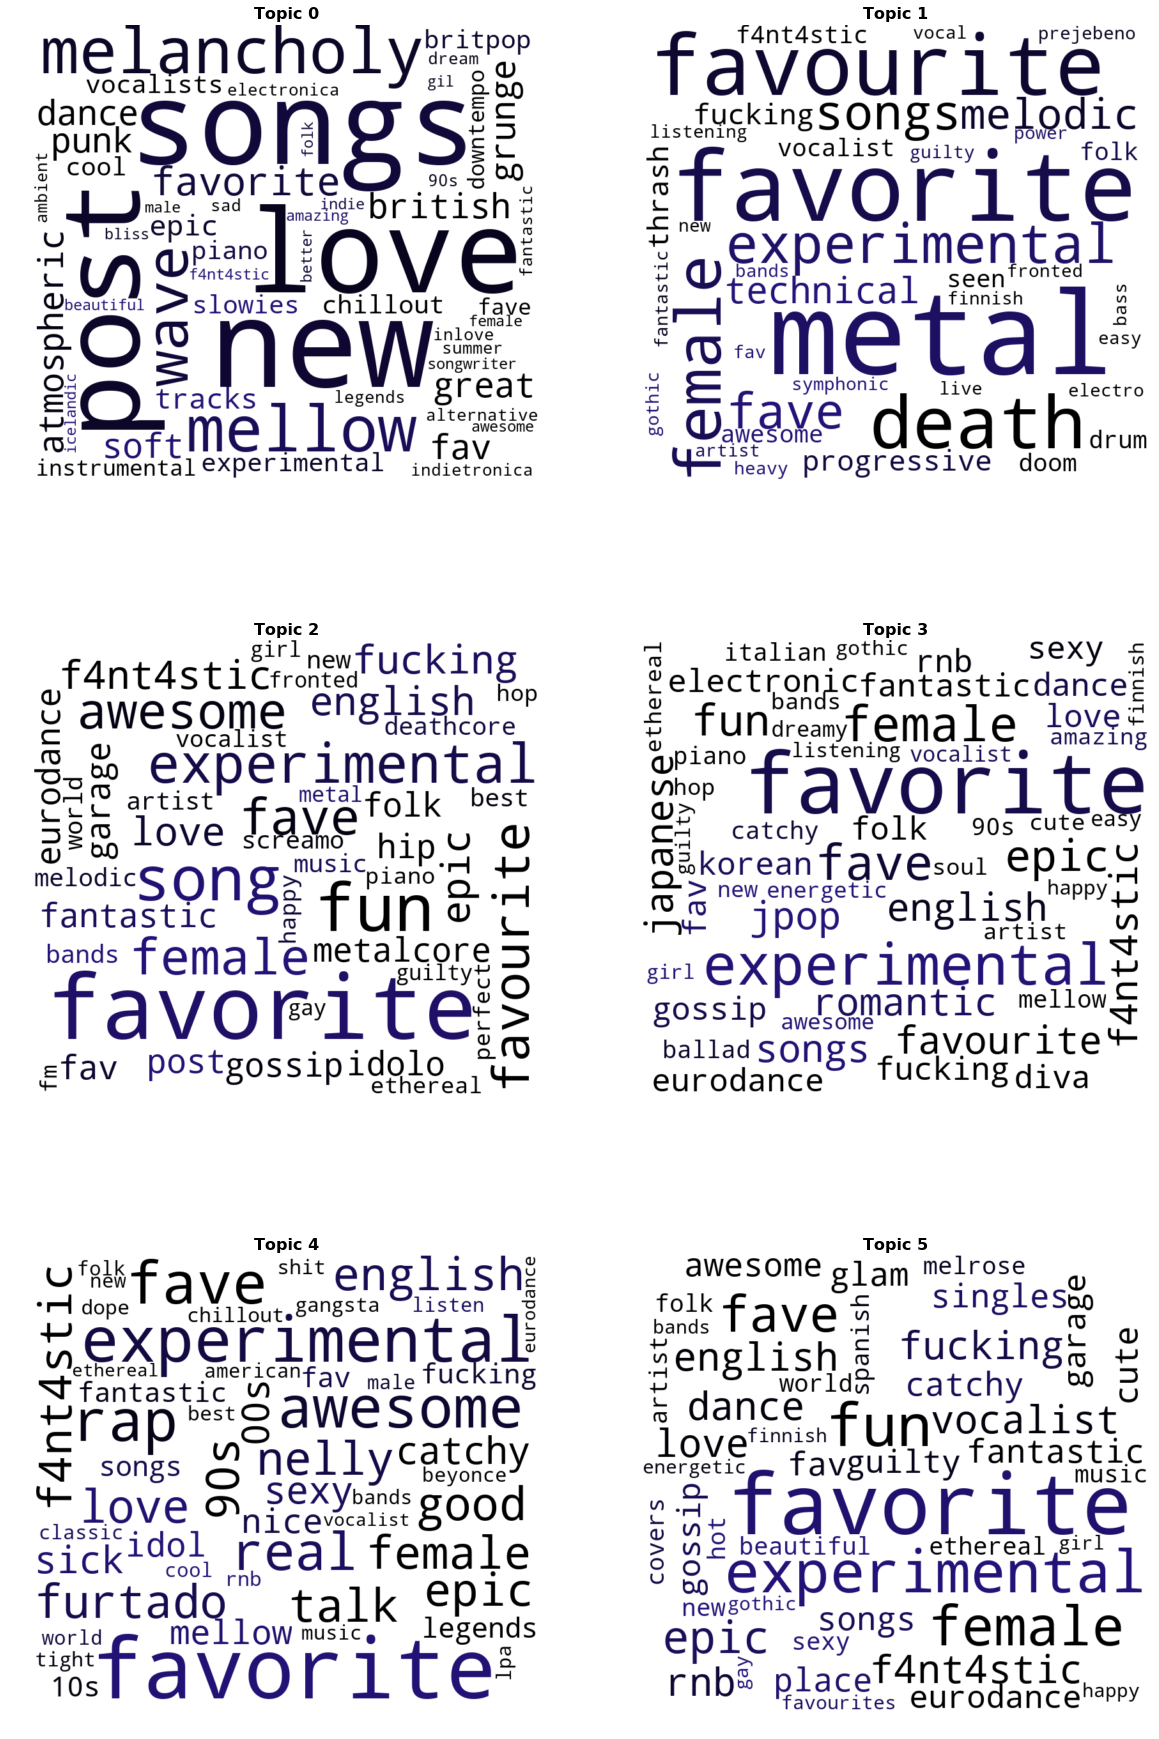

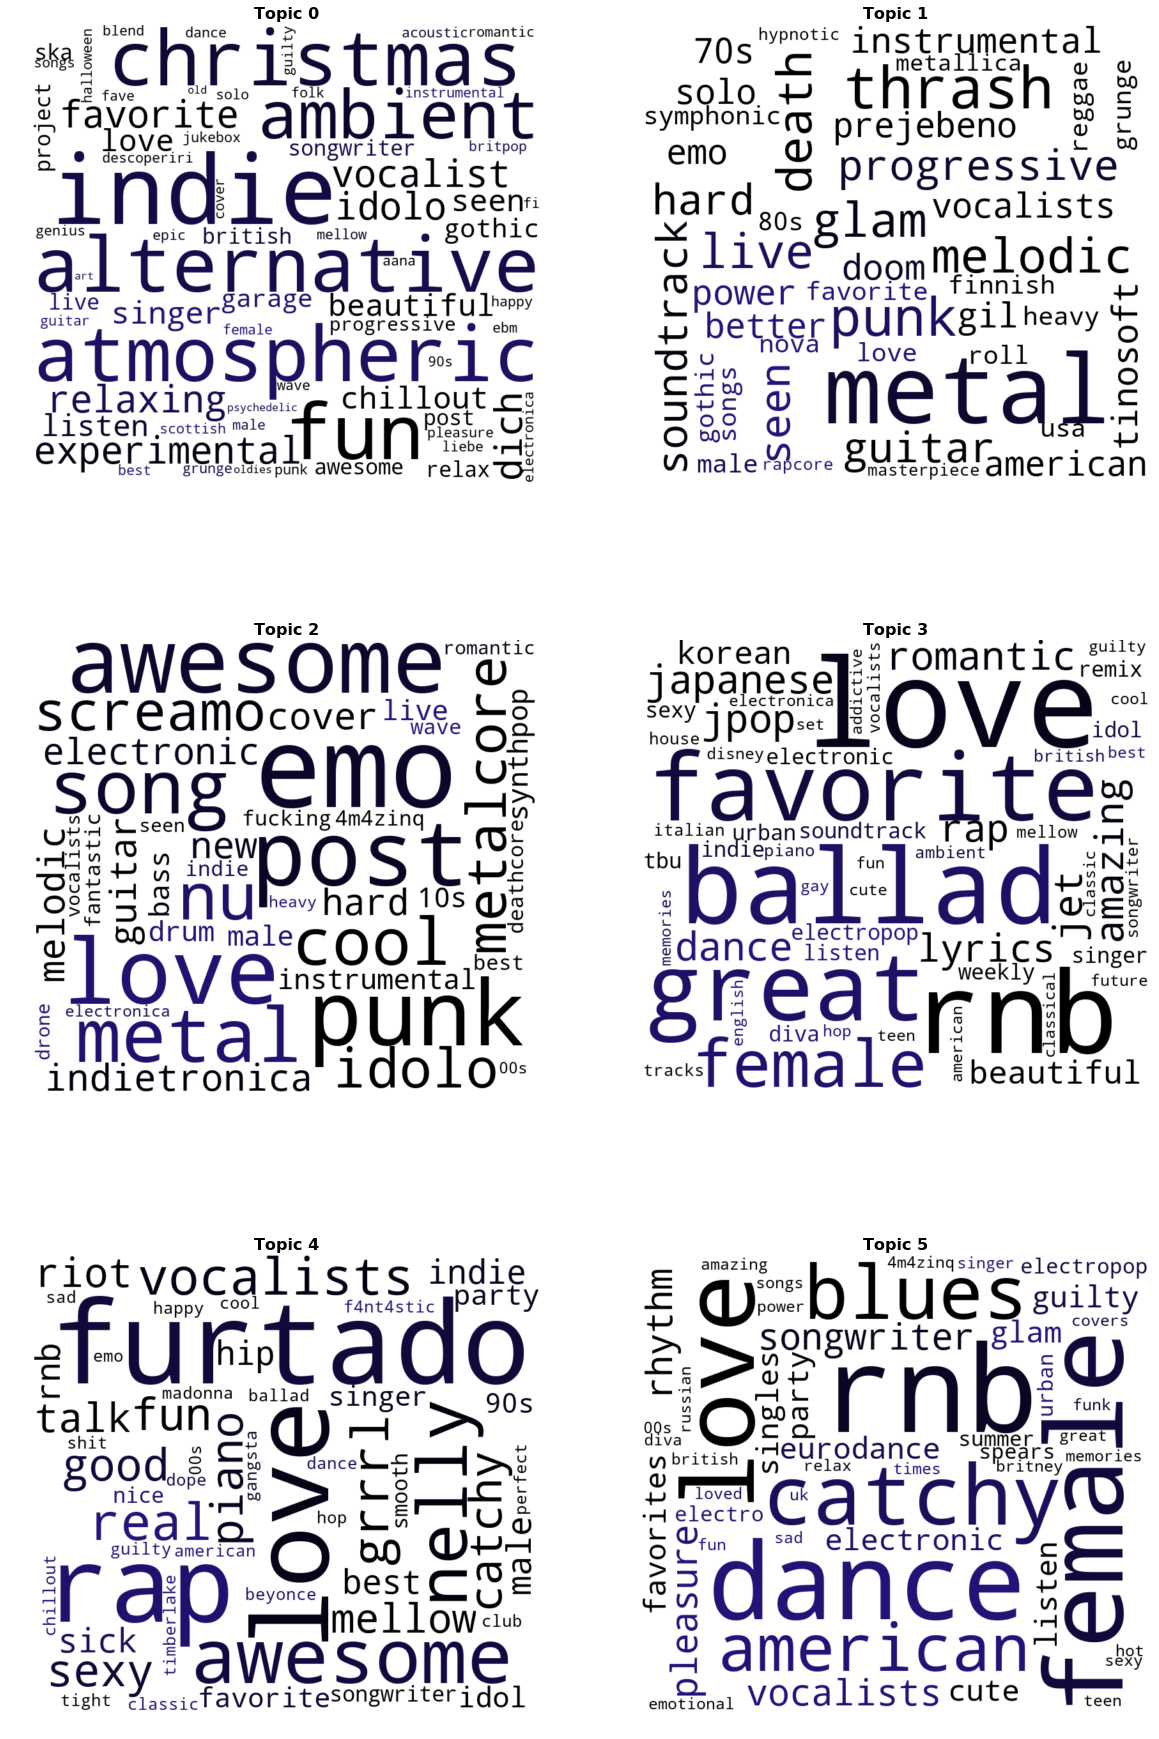

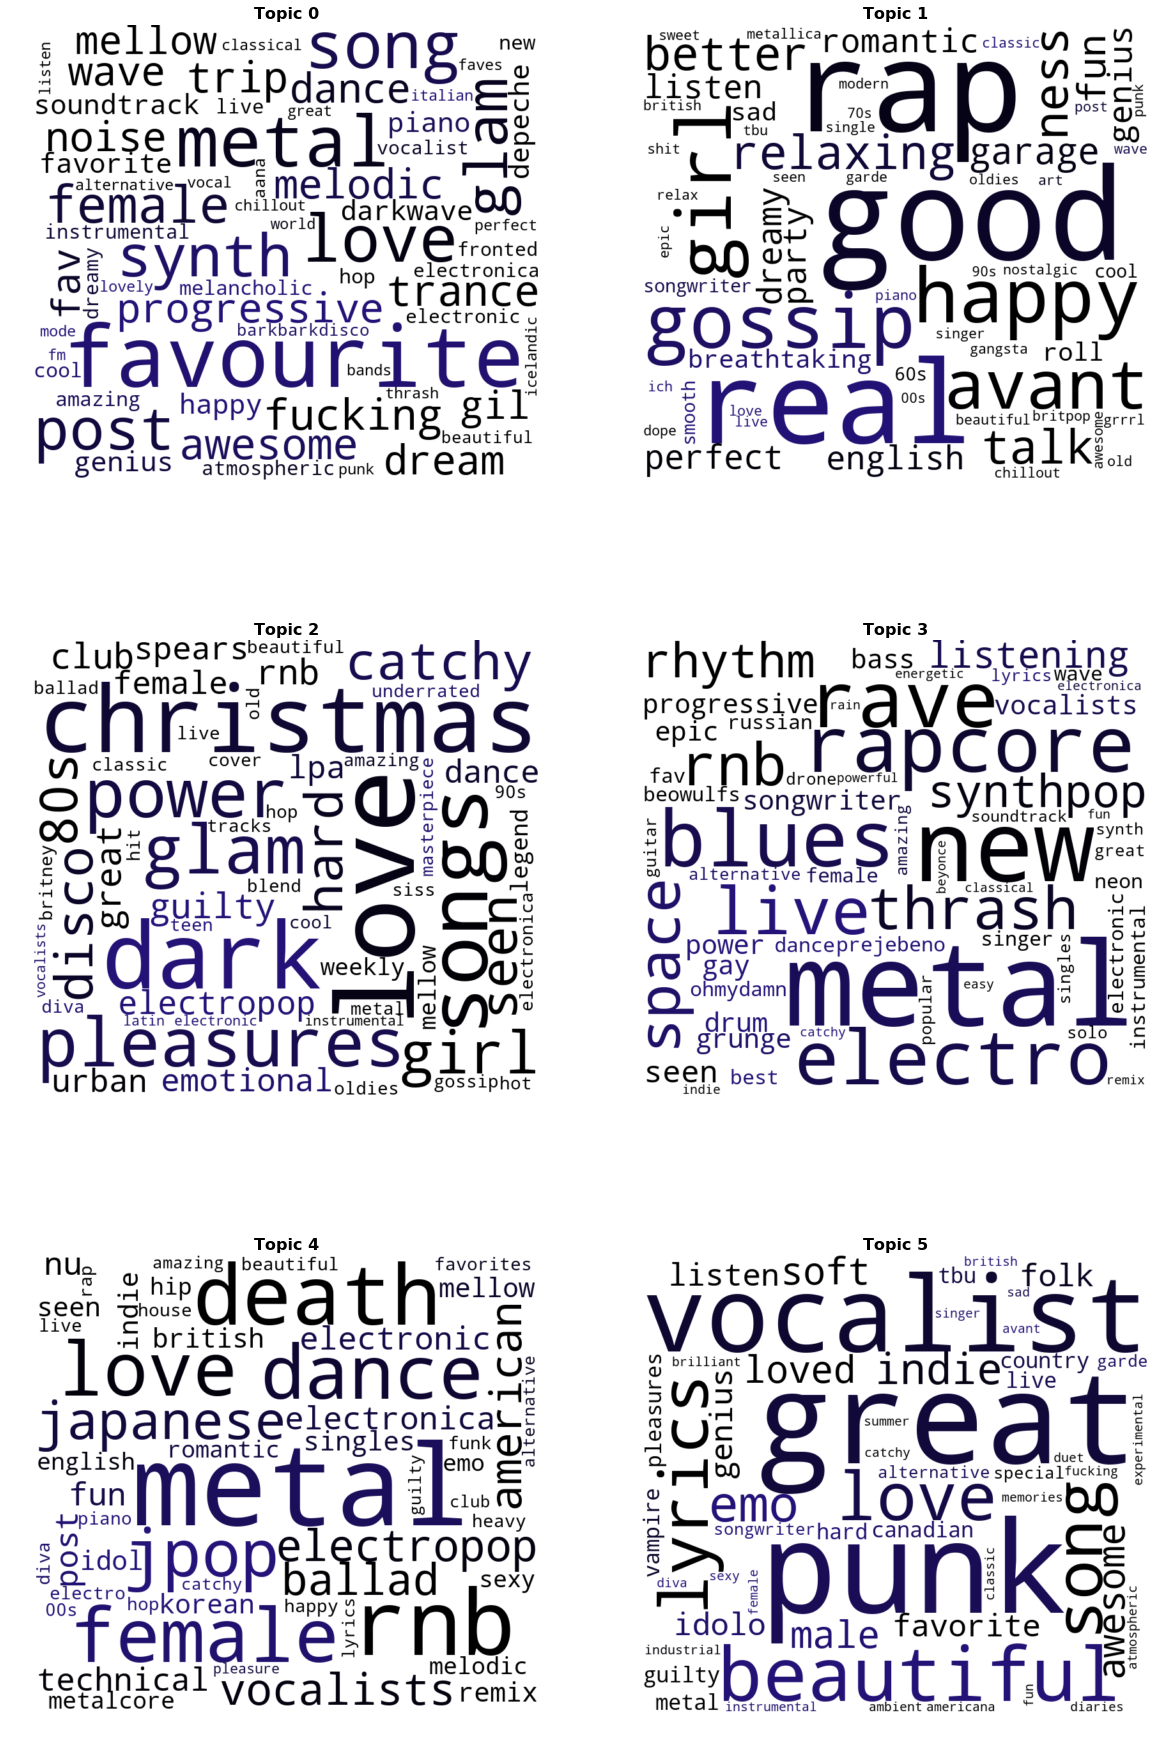

In [56]:
class_tfidfnmf = {}
for item in class_list:
#     if item == 'all':
#         data = tag_data.tags
#     else:
#         data = dataset[dataset[item]==1]

    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range,
                                       max_df=max_df, 
                                       min_df=min_df,
                                       max_features=n_features,
                                       stop_words='english')
    
    tfidf = tfidf_vectorizer.fit_transform(data)

    tf_vectorizer = CountVectorizer(ngram_range=ngram_range,
                                    max_df=max_df, 
                                    min_df=min_df,
                                    max_features=n_features,
                                    stop_words='english')
    
    tf = tf_vectorizer.fit_transform(data)

    nmf = NMF(n_components=n_topics, 
              random_state=seed,
              alpha=.1, 
              l1_ratio=.5).fit(tfidf)

    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    aa = print_top_words(nmf, 
                         tfidf_feature_names, 
                         n_top_words)

    nmf = NMF(n_components=n_topics, 
              random_state=seed,
              beta_loss='kullback-leibler', 
              solver='mu', 
              max_iter=max_iter, 
              alpha=.1,
              l1_ratio=.5).fit(tfidf)

    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    bb = print_top_words(nmf, 
                         tfidf_feature_names, 
                         n_top_words)

    lda = LatentDirichletAllocation(n_components=n_topics, 
                                    max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=seed)
    lda.fit(tf)

    tf_feature_names = tf_vectorizer.get_feature_names()

    cc = print_top_words(lda, 
                         tf_feature_names, 
                         n_top_words)
    
    class_tfidfnmf[item] = {'NMF-FN':aa, 'NMF-KL':bb, 'LDA':cc}
    
    # plot wordclouds
    for e in class_tfidfnmf[item]:
        fig = plt.figure(figsize=(20,100))
        chart_tot = n_topics * len(class_list) * len(model_list)
        ncols = ncols
        nrows = math.ceil(chart_tot / ncols)
        for i in range(n_topics):
            ax = fig.add_subplot(nrows,ncols,i+1)
            text = ' '.join(class_tfidfnmf[item][e][i].split()[2:])
            title = "Topic: " + str(item) + "_" + str(e) + "_" + "_" + str(i)
            
            generate_wordcloud(text)
            
        filepath = '../charts/tfidfnmflda_wc' + str(item) + str(e)
        plt.savefig(filepath)
        print('saved at ' + filepath)

### Word2Vec

In [57]:
documents = tag_data.tags
texts = [[word for word in document.lower().split() if word not in sw]
         for document in documents]

In [58]:
model = gensim.models.Word2Vec(texts, size=100, window=10, min_count=1, workers=2,sg=1)

In [59]:
# list(model.wv.vocab.items())

In [60]:
len(model.wv.vocab.items())

524

In [61]:
model.most_similar('metal',topn=8)

/Users/brianmcmahon/anaconda3/envs/recommender/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('thrash', 0.9982839822769165),
 ('speed', 0.9944168329238892),
 ('symphonic', 0.9864040613174438),
 ('nu-metal,', 0.9748964309692383),
 ('swedish,', 0.9712797403335571),
 ('screamo,', 0.9707544445991516),
 ('hard,', 0.9678231477737427),
 ('metalcore,', 0.9675101041793823)]

In [62]:
model.most_similar('teen',topn=8)

/Users/brianmcmahon/anaconda3/envs/recommender/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('soul,', 0.9969702959060669),
 ('summer', 0.994310736656189),
 ('stuff,', 0.9913506507873535),
 ('sexy,', 0.9883567690849304),
 ('sick,', 0.985488772392273),
 ('spanish,', 0.9837727546691895),
 ('smooth,', 0.9790351986885071),
 ('tight,', 0.9775396585464478)]

In [63]:
model.most_similar('80s',topn=8)

/Users/brianmcmahon/anaconda3/envs/recommender/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[("80's,", 0.9964423179626465),
 ('1996,', 0.9964389801025391),
 ('1992,', 0.9963712096214294),
 ('1982,', 0.9961010217666626),
 ('album', 0.9954497218132019),
 ('alsolike,', 0.9952144622802734),
 ('1995,', 0.9943733811378479),
 ('aana,', 0.9941436052322388)]

In [64]:
model.most_similar('romantic',topn=8)

/Users/brianmcmahon/anaconda3/envs/recommender/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('jamaican,', 0.9958163499832153),
 ('swing', 0.9953628778457642),
 ('edge', 0.9952291250228882),
 ('babe', 0.9951599836349487),
 ('twee', 0.9926145672798157),
 ('3mmey', 0.9922956228256226),
 ('special', 0.991149365901947),
 ('shoegaze', 0.9895126819610596)]

In [65]:
model.similarity('techno','metal')

/Users/brianmcmahon/anaconda3/envs/recommender/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.5044180083585266

### pyLDAvis

In [66]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(data)
print(dtm_tf.shape)

(505, 264)


In [67]:
lda_tf = LatentDirichletAllocation(n_topics=n_topics, random_state=seed)
lda_tf.fit(dtm_tf)

/Users/brianmcmahon/anaconda3/envs/recommender/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/Users/brianmcmahon/anaconda3/envs/recommender/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1, n_topics=6,
             perp_tol=0.1, random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [68]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

/Users/brianmcmahon/anaconda3/envs/recommender/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=           x      y  topics  cluster   Freq
topic                                      
4     -0.086  0.109       1        1 28.551
3      0.074  0.059       2        1 22.749
2     -0.184  0.094       3        1 14.102
1     -0.029 -0.094       4        1 12.988
0      0.264  0.044       5        1 12.928
5     -0.038 -0.212       6        1  8.683, topic_info=     Category    Freq          Term   Total  loglift  logprob
term                                                         
160   Default 391.000         metal 391.000   30.000   30.000
85    Default 415.000        female 415.000   29.000   29.000
128   Default 462.000         indie 462.000   28.000   28.000
168   Default 157.000           new 157.000   27.000   27.000
120   Default 140.000           hop 140.000   26.000   26.000
192   Default 247.000          punk 247.000   25.000   25.000
260   Default 117.000          wave 117.000   24.000   24.000
118   Default 106.000           hip 106.000   23.000   23.000
114   Default 122.000          hard 122.000   22.000   22.000
46    Default 206.000         dance 206.000   21.000   21.000
117   Default  59.000         heavy  59.000   20.000   20.000
64    Default 188.000    electronic 188.000   19.000   19.000
189   Default  98.000   progressive  98.000   18.000   18.000
6     Default  72.000       ambient  72.000   17.000   17.000
115   Default  99.000      hardcore  99.000   16.000   16.000
75    Default 105.000  experimental 105.000   15.000   15.000
239   Default  61.000      synthpop  61.000   14.000   14.000
184   Default 144.000          post 144.000   13.000   13.000
30    Default 122.000        catchy 122.000   12.000   12.000
26    Default 134.000       british 134.000   11.000   11.000
62    Default  99.000       electro  99.000   10.000   10.000
238   Default  38.000         synth  38.000    9.000    9.000
65    Default  89.000   electronica  89.000    8.000    8.000
199   Default  61.000         remix  61.000    7.000    7.000
132   Default  95.000  instrumental  95.000    6.000    6.000
48    Default  40.000         death  40.000    5.000    5.000
200   Default  77.000           rnb  77.000    4.000    4.000
201   Default  67.000          roll  67.000    3.000    3.000
67    Default  90.000           emo  90.000    2.000    2.000
191   Default  72.000   psychedelic  72.000    1.000    1.000
...       ...     ...           ...     ...      ...      ...
168    Topic6  93.322           new 157.166    1.923   -2.615
248    Topic6   9.892        trance  17.012    1.902   -4.859
241    Topic6  14.189        techno  24.452    1.899   -4.498
39     Topic6   7.957       college  14.119    1.870   -5.077
79     Topic6  11.755         faves  21.617    1.835   -4.687
52     Topic6  15.825         disco  31.050    1.770   -4.389
16     Topic6  12.889         bands  25.513    1.761   -4.595
71     Topic6   6.276       england  12.442    1.759   -5.314
199    Topic6  26.749         remix  61.809    1.606   -3.865
99     Topic6   4.781        german  11.667    1.552   -5.586
130    Topic6  12.752    industrial  31.659    1.534   -4.605
105    Topic6  15.601        gothic  42.296    1.446   -4.404
26     Topic6  44.897       british 134.958    1.343   -3.347
194    Topic6   6.428          rain  19.685    1.325   -5.290
228    Topic6   6.068         space  21.275    1.189   -5.348
65     Topic6  24.986   electronica  89.769    1.165   -3.933
62     Topic6  25.954       electro  99.727    1.098   -3.895
122    Topic6   9.991         house  39.559    1.068   -4.849
132    Topic6  23.703  instrumental  95.755    1.048   -3.985
64     Topic6  38.976    electronic 188.732    0.866   -3.488
46     Topic6  32.270         dance 206.757    0.586   -3.677
81     Topic6  25.226     favorites 173.809    0.514   -3.923
202    Topic6  16.017      romantic  86.126    0.762   -4.377
80     Topic6  21.313      favorite 210.754    0.152   -4.092
75     Topic6  14.669  experimental 105.547    0.470   -4.465
151    To

In [69]:
# 1. teen pop
# 2. punk
# 3. hip hop
# 4. electronic
# 5. heavy metal
# 6. electronic

In [70]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='mmds')

/Users/brianmcmahon/anaconda3/envs/recommender/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=           x      y  topics  cluster   Freq
topic                                      
4     -0.101  0.085       1        1 28.551
3      0.177  0.009       2        1 22.749
2     -0.203  0.041       3        1 14.102
1      0.089 -0.161       4        1 12.988
0      0.150  0.249       5        1 12.928
5     -0.111 -0.223       6        1  8.683, topic_info=     Category    Freq          Term   Total  loglift  logprob
term                                                         
160   Default 391.000         metal 391.000   30.000   30.000
85    Default 415.000        female 415.000   29.000   29.000
128   Default 462.000         indie 462.000   28.000   28.000
168   Default 157.000           new 157.000   27.000   27.000
120   Default 140.000           hop 140.000   26.000   26.000
192   Default 247.000          punk 247.000   25.000   25.000
260   Default 117.000          wave 117.000   24.000   24.000
118   Default 106.000           hip 106.000   23.000   23.000
114   Default 122.000          hard 122.000   22.000   22.000
46    Default 206.000         dance 206.000   21.000   21.000
117   Default  59.000         heavy  59.000   20.000   20.000
64    Default 188.000    electronic 188.000   19.000   19.000
189   Default  98.000   progressive  98.000   18.000   18.000
6     Default  72.000       ambient  72.000   17.000   17.000
115   Default  99.000      hardcore  99.000   16.000   16.000
75    Default 105.000  experimental 105.000   15.000   15.000
239   Default  61.000      synthpop  61.000   14.000   14.000
184   Default 144.000          post 144.000   13.000   13.000
30    Default 122.000        catchy 122.000   12.000   12.000
26    Default 134.000       british 134.000   11.000   11.000
62    Default  99.000       electro  99.000   10.000   10.000
238   Default  38.000         synth  38.000    9.000    9.000
65    Default  89.000   electronica  89.000    8.000    8.000
199   Default  61.000         remix  61.000    7.000    7.000
132   Default  95.000  instrumental  95.000    6.000    6.000
48    Default  40.000         death  40.000    5.000    5.000
200   Default  77.000           rnb  77.000    4.000    4.000
201   Default  67.000          roll  67.000    3.000    3.000
67    Default  90.000           emo  90.000    2.000    2.000
191   Default  72.000   psychedelic  72.000    1.000    1.000
...       ...     ...           ...     ...      ...      ...
168    Topic6  93.322           new 157.166    1.923   -2.615
248    Topic6   9.892        trance  17.012    1.902   -4.859
241    Topic6  14.189        techno  24.452    1.899   -4.498
39     Topic6   7.957       college  14.119    1.870   -5.077
79     Topic6  11.755         faves  21.617    1.835   -4.687
52     Topic6  15.825         disco  31.050    1.770   -4.389
16     Topic6  12.889         bands  25.513    1.761   -4.595
71     Topic6   6.276       england  12.442    1.759   -5.314
199    Topic6  26.749         remix  61.809    1.606   -3.865
99     Topic6   4.781        german  11.667    1.552   -5.586
130    Topic6  12.752    industrial  31.659    1.534   -4.605
105    Topic6  15.601        gothic  42.296    1.446   -4.404
26     Topic6  44.897       british 134.958    1.343   -3.347
194    Topic6   6.428          rain  19.685    1.325   -5.290
228    Topic6   6.068         space  21.275    1.189   -5.348
65     Topic6  24.986   electronica  89.769    1.165   -3.933
62     Topic6  25.954       electro  99.727    1.098   -3.895
122    Topic6   9.991         house  39.559    1.068   -4.849
132    Topic6  23.703  instrumental  95.755    1.048   -3.985
64     Topic6  38.976    electronic 188.732    0.866   -3.488
46     Topic6  32.270         dance 206.757    0.586   -3.677
81     Topic6  25.226     favorites 173.809    0.514   -3.923
202    Topic6  16.017      romantic  86.126    0.762   -4.377
80     Topic6  21.313      favorite 210.754    0.152   -4.092
75     Topic6  14.669  experimental 105.547    0.470   -4.465
151    To

In [71]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='tsne')

/Users/brianmcmahon/anaconda3/envs/recommender/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            x       y  topics  cluster   Freq
topic                                        
4      93.013  41.924       1        1 28.551
3      -7.257 -72.205       2        1 22.749
2       6.779  79.065       3        1 14.102
1     -55.191   8.529       4        1 12.988
0      84.338 -51.566       5        1 12.928
5      24.337   1.149       6        1  8.683, topic_info=     Category    Freq          Term   Total  loglift  logprob
term                                                         
160   Default 391.000         metal 391.000   30.000   30.000
85    Default 415.000        female 415.000   29.000   29.000
128   Default 462.000         indie 462.000   28.000   28.000
168   Default 157.000           new 157.000   27.000   27.000
120   Default 140.000           hop 140.000   26.000   26.000
192   Default 247.000          punk 247.000   25.000   25.000
260   Default 117.000          wave 117.000   24.000   24.000
118   Default 106.000           hip 106.000   23.000   23.000
114   Default 122.000          hard 122.000   22.000   22.000
46    Default 206.000         dance 206.000   21.000   21.000
117   Default  59.000         heavy  59.000   20.000   20.000
64    Default 188.000    electronic 188.000   19.000   19.000
189   Default  98.000   progressive  98.000   18.000   18.000
6     Default  72.000       ambient  72.000   17.000   17.000
115   Default  99.000      hardcore  99.000   16.000   16.000
75    Default 105.000  experimental 105.000   15.000   15.000
239   Default  61.000      synthpop  61.000   14.000   14.000
184   Default 144.000          post 144.000   13.000   13.000
30    Default 122.000        catchy 122.000   12.000   12.000
26    Default 134.000       british 134.000   11.000   11.000
62    Default  99.000       electro  99.000   10.000   10.000
238   Default  38.000         synth  38.000    9.000    9.000
65    Default  89.000   electronica  89.000    8.000    8.000
199   Default  61.000         remix  61.000    7.000    7.000
132   Default  95.000  instrumental  95.000    6.000    6.000
48    Default  40.000         death  40.000    5.000    5.000
200   Default  77.000           rnb  77.000    4.000    4.000
201   Default  67.000          roll  67.000    3.000    3.000
67    Default  90.000           emo  90.000    2.000    2.000
191   Default  72.000   psychedelic  72.000    1.000    1.000
...       ...     ...           ...     ...      ...      ...
168    Topic6  93.322           new 157.166    1.923   -2.615
248    Topic6   9.892        trance  17.012    1.902   -4.859
241    Topic6  14.189        techno  24.452    1.899   -4.498
39     Topic6   7.957       college  14.119    1.870   -5.077
79     Topic6  11.755         faves  21.617    1.835   -4.687
52     Topic6  15.825         disco  31.050    1.770   -4.389
16     Topic6  12.889         bands  25.513    1.761   -4.595
71     Topic6   6.276       england  12.442    1.759   -5.314
199    Topic6  26.749         remix  61.809    1.606   -3.865
99     Topic6   4.781        german  11.667    1.552   -5.586
130    Topic6  12.752    industrial  31.659    1.534   -4.605
105    Topic6  15.601        gothic  42.296    1.446   -4.404
26     Topic6  44.897       british 134.958    1.343   -3.347
194    Topic6   6.428          rain  19.685    1.325   -5.290
228    Topic6   6.068         space  21.275    1.189   -5.348
65     Topic6  24.986   electronica  89.769    1.165   -3.933
62     Topic6  25.954       electro  99.727    1.098   -3.895
122    Topic6   9.991         house  39.559    1.068   -4.849
132    Topic6  23.703  instrumental  95.755    1.048   -3.985
64     Topic6  38.976    electronic 188.732    0.866   -3.488
46     Topic6  32.270         dance 206.757    0.586   -3.677
81     Topic6  25.226     favorites 173.809    0.514   -3.923
202    Topic6  16.017      romantic  86.126    0.762   -4.377
80     Topic6  21.313      favorite 210.754    0.152   -4.092
75     Topic6  14.669  experimental 105.547    0.470   

In [72]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
output_notebook()

Loading BokehJS ...

In [73]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words='english', lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')

data_vectorized = vectorizer.fit_transform(tag_data.tags)

In [74]:
svd = TruncatedSVD(n_components=2)
documents_2d = svd.fit_transform(data_vectorized)
 
df = pd.DataFrame(columns=['x', 'y', 'document'])
df['x'], df['y'], df['document'] = documents_2d[:,0], documents_2d[:,1], range(len(data))
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="document", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

In [75]:
svd = TruncatedSVD(n_components=2)
words_2d = svd.fit_transform(data_vectorized.T)
 
df = pd.DataFrame(columns=['x', 'y', 'word'])
df['x'], df['y'], df['word'] = words_2d[:,0], words_2d[:,1], vectorizer.get_feature_names()
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="word", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)